# Predictive Analytics

In [1]:
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import adam
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## LSTM

## Importing data using Pandas

In [3]:
df_full_daily = pd.read_csv('Data/3.Data Preparation/df_full_hourly.csv')
df_full_daily.drop([df_full_daily.columns[0], 'no_solar_panels'], axis=1, inplace=True)

In [4]:
display(df_full_daily.head())
display(df_full_daily.shape)

,delivery,consumption,T,SQ,Q,N,hour,day_of_week,day_of_month,week,month,season,heating_sys,no_people,sp_group
0,0.0,0.403,16.6,0.0,0.0,8.0,1,1,11,28,7,2,1,4.0,3
1,0.0,0.089,16.7,0.0,0.0,6.0,2,1,11,28,7,2,1,4.0,3
2,0.0,0.108,16.9,0.0,0.0,7.0,3,1,11,28,7,2,1,4.0,3
3,0.0,0.088,16.7,0.0,2.0,7.0,4,1,11,28,7,2,1,4.0,3
4,0.0,0.087,17.0,2.0,13.0,6.0,5,1,11,28,7,2,1,4.0,3


(402057, 15)

### Normalizing data

In [5]:
df_full_daily.columns[:-3]

Index(['delivery', 'consumption', 'T', 'SQ', 'Q', 'N', 'hour', 'day_of_week',
       'day_of_month', 'week', 'month', 'season'],
      dtype='object')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_to_norm = df_full_daily[df_full_daily.columns[:-3]]
df_norm = pd.DataFrame(scaler.fit_transform(df_to_norm.astype('float')))

In [7]:
display(df_norm.head())
display(df_norm.shape)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.047715,0.585882,0.0,0.000000,0.888889,0.043478,0.166667,0.333333,0.529412,0.545455,0.333333
1,0.0,0.010538,0.588235,0.0,0.000000,0.666667,0.086957,0.166667,0.333333,0.529412,0.545455,0.333333
2,0.0,0.012787,0.592941,0.0,0.000000,0.777778,0.130435,0.166667,0.333333,0.529412,0.545455,0.333333
3,0.0,0.010419,0.588235,0.0,0.005970,0.777778,0.173913,0.166667,0.333333,0.529412,0.545455,0.333333
4,0.0,0.010301,0.595294,0.2,0.038806,0.666667,0.217391,0.166667,0.333333,0.529412,0.545455,0.333333


(402057, 12)

In [8]:
divisions = [] 
difference = np.inf
day = 2 #Select the number of days you want to make your predictions on 

for i in range(df_norm.shape[0]):
    if (df_norm.shape[0] % (i+1) == 0):
        divisions.append(i+1)
        diff = abs((96*day)-(i+1))
        if difference > diff:
            difference = diff
            rows = i+1
        else:
            pass
        
samples = int(df_full_daily.shape[0] / rows)

In [9]:
#14891 samples #27 rows per house #15 features per dwelling
X = df_norm.values.reshape(samples, rows, df_norm.shape[1]) 
X.shape

(14891, 27, 12)

In [10]:
y = np.zeros((df_full_daily['heating_sys'].shape[0], 3))

for i in range(len(df_full_daily['heating_sys'])):
    if df_full_daily['heating_sys'][i] == 1:
        y[i] = [1,0,0]
    elif df_full_daily['heating_sys'][i] == 2:
        y[i] = [0,1,0]
    else:
        y[i] = [0,0,1]
        
y.shape

(402057, 3)

In [11]:
y = y.reshape(samples, rows, y.shape[1])
y.shape

(14891, 27, 3)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()

# Recurrent layer
model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Fully connected layer
model.add(Dropout(0.25))
model.add(Dense(20, activation='relu')) #relu/linear

# Output layer
model.add(Dense(3, activation='softmax')) #softmax/softmax para cada tipo de neurona

In [13]:
lr= 0.003 #lr= 0.01 25 epochs got 75% validation accuracy and 96% final accuracy
            #0.03 25 epochs got 35% validation accuracy and 36% final accuracy
    
opt = adam(lr=0.003)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [14]:
y_train = y_train.astype(int)

history = model.fit(X_train, y_train, epochs = 60, validation_data=(X_test, y_test))

Train on 10423 samples, validate on 4468 samples
Epoch 1/60
10423/10423 [==============================] - 10s 976us/step - loss: 0.2097 - acc: 0.4585 - val_loss: 0.2087 - val_acc: 0.4651
Epoch 2/60
10423/10423 [==============================] - 9s 903us/step - loss: 0.2025 - acc: 0.5119 - val_loss: 0.2018 - val_acc: 0.5072
Epoch 3/60
10423/10423 [==============================] - 9s 906us/step - loss: 0.1878 - acc: 0.5571 - val_loss: 0.1743 - val_acc: 0.5911
Epoch 4/60
10423/10423 [==============================] - 10s 917us/step - loss: 0.1677 - acc: 0.6149 - val_loss: 0.1792 - val_acc: 0.5686
Epoch 5/60
10423/10423 [==============================] - 10s 923us/step - loss: 0.1552 - acc: 0.6516 - val_loss: 0.1487 - val_acc: 0.6699
Epoch 6/60
10423/10423 [==============================] - 10s 918us/step - loss: 0.1513 - acc: 0.6615 - val_loss: 0.1496 - val_acc: 0.6667
Epoch 7/60
10423/10423 [==============================] - 10s 921us/step - loss: 0.1462 - acc: 0.6745 - val_loss: 0.146

10423/10423 [==============================] - 10s 937us/step - loss: 0.0826 - acc: 0.8233 - val_loss: 0.0963 - val_acc: 0.7944
Epoch 60/60
10423/10423 [==============================] - 10s 925us/step - loss: 0.0818 - acc: 0.8248 - val_loss: 0.0951 - val_acc: 0.7976


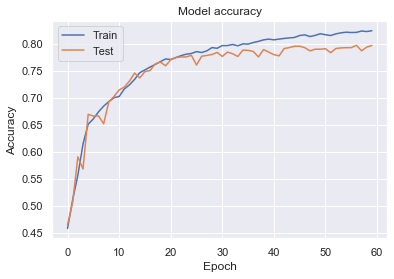

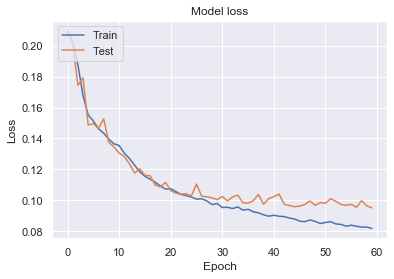

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
X_predict = model.predict(X_test)

In [17]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0]
    elif X_predict_round[i][rows-1][2] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,1]

In [18]:
accuracy = np.empty(len(y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False
 
print('Accuracy: ' + str(round(np.mean(accuracy)*100,1)) + '%')

Accuracy: 91.5%
